In [327]:
import pandas as pd
from tqdm.auto import tqdm

df = pd.read_csv('csv1.csv')

In [328]:
df.head()

,paper,article_index,sentence,I/P,model1 score,model1 label,model2 score,model2 label,model3 score,model3 label,...,model5 score,model5 label,model6 score,model6 label,model7 score,model7 label,majority,absolute-majority,AVG-majority-score,AVG-absolute-majority-score
0,A-J,0,pope francis has renewed calls for an immediat...,P,0.801705,POS,0.432372,POS,0.407419,NUT,...,0.461482,NEG,0.716461,POS,0.997451,NUT,POS,POS,0.737294,0.737294
1,A-J,0,"pope renews call for gaza ceasefire, release o...",P,0.791487,NUT,0.468124,NEG,0.724179,NEG,...,0.472699,NEG,0.920949,NUT,0.998320,NUT,NaN,NaN,NaN,NaN
2,A-J,1,united states president ronald reagan’s order ...,I,0.783303,NUT,0.276533,POS,0.702795,NEG,...,0.501513,NEG,0.702552,NUT,0.994342,NUT,NUT,NaN,0.826732,NaN
3,A-J,1,biden is still the best us president israel co...,I,0.968796,POS,0.715602,POS,0.577471,POS,...,0.811250,POS,0.987807,POS,0.999273,POS,POS,POS,0.865553,0.865553
4,A-J,2,israeli air strikes continue across gaza as tr...,P,0.722233,NEG,0.258997,POS,0.868871,NEG,...,0.472687,NEG,0.928277,NEG,0.995305,NUT,NEG,NEG,0.797589,0.797589


In [329]:
# Label normalization
positive_labels = ['POSITIVE', 'positive', '4 stars', '5 stars', 'POS']
negative_labels = ['NEGATIVE', 'negative', '1 star', '2 stars', 'NEG']

def normalize_label(label):
    if label in positive_labels:
        return 'POS'
    elif label in negative_labels:
        return 'NEG'
    else:
        return 'NUT'

In [330]:
def get_classification(row):
    labels_counts = {'POS':0, 'NEG':0, 'NUT':0}
    for key, value in row.items():
        if 'label' in key:
            labels_counts[normalize_label(value)] += 1
    if labels_counts['POS'] >= 6 or (labels_counts['POS'] >= 5 and labels_counts['NEG'] == 0):
        return 'POS'
    elif labels_counts['NEG'] >= 6 or (labels_counts['NEG'] >= 5 and labels_counts['POS'] == 0):
        return 'NEG'
    elif labels_counts['NUT'] >= 6 or (labels_counts['NUT'] >= 5 and labels_counts['POS'] == 1 and labels_counts['NEG'] == 1):
        return 'NUT'
    else:
        return 'N/A'



In [331]:
break_point = int(df.shape[0] * 0.82)
train_df = df.iloc[:break_point]
test_df = df.iloc[break_point:]

In [332]:
def categorize_df(df):
    categories = {
        'pro_i': [],
        'pro_p': [],
        'anti_i': [],
        'anti_p': [],
        'neutral': []
    }

    for index, row in df.iterrows():
        classification = get_classification(row)
        if classification != 'N/A':
            if classification == 'POS':
                if row['I/P'] == 'I':
                    categories['pro_i'].append(row['sentence'])
                elif row['I/P'] == 'P':
                    categories['pro_p'].append(row['sentence'])
            elif classification == 'NEG':
                if row['I/P'] == 'I':
                    categories['anti_i'].append(row['sentence'])
                elif row['I/P'] == 'P':
                    categories['anti_p'].append(row['sentence'])
            elif classification == 'NUT':
                categories['neutral'].append(row['sentence'])

    # Print the counts
    print(len(categories['pro_i']), len(categories['pro_p']), len(categories['anti_i']), len(categories['anti_p']), len(categories['neutral']))

    min_length = min(len(lst) for lst in categories.values())

    # Truncate all lists to the minimum length
    for key in categories:
        categories[key] = categories[key][:min_length]

    # Print the counts and truncated lists
    print(len(categories['pro_i']), len(categories['pro_p']), len(categories['anti_i']), len(categories['anti_p']), len(categories['neutral']))
    return categories

train_categories = categorize_df(train_df)
test_categories = categorize_df(test_df)

226 73 2557 1487 210
73 73 73 73 73
53 13 480 287 57
13 13 13 13 13


In [333]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

In [334]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [335]:
# Define label mapping
label_mapping = {"pro_i": 0, "pro_p": 1, "anti_i": 2, "anti_p": 3, "neutral": 4}
def flatten_dict(dictionary):
    # Flatten the dictionary into texts and labels
    texts = []
    labels = []

    for category, sentences in dictionary.items():
        texts.extend(sentences)
        labels.extend([label_mapping[category]] * len(sentences))

    return texts, labels

train_texts, train_labels = flatten_dict(train_categories)
test_texts, test_labels = flatten_dict(test_categories)

In [336]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split (
    train_texts, train_labels, train_size=0.85, random_state=42, shuffle=True
)

In [337]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)


train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_data = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_data_tokenized = train_data.map(tokenize_function, batched=True)
val_data_tokenized = val_data.map(tokenize_function, batched=True)

train_data_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 55/55 [00:00<00:00, 3226.70 examples/s]


In [338]:
from transformers import AutoModelForSequenceClassification

# Load DistilBERT for sequence classification (5 categories)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [339]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
)


In [340]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_tokenized,
    eval_dataset=val_data_tokenized,
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.523429
2,No log,1.260421
3,No log,0.970040
4,No log,0.809089
5,1.095500,0.732613
6,1.095500,0.701658
7,1.095500,0.680978
8,1.095500,0.668211
9,1.095500,0.657817
10,0.370200,0.657469


TrainOutput(global_step=200, training_loss=0.732823314666748, metrics={'train_runtime': 66.515, 'train_samples_per_second': 46.606, 'train_steps_per_second': 3.007, 'total_flos': 102667726464000.0, 'train_loss': 0.732823314666748, 'epoch': 10.0})

In [341]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

('./fine_tuned_bert\\tokenizer_config.json',
 './fine_tuned_bert\\special_tokens_map.json',
 './fine_tuned_bert\\vocab.txt',
 './fine_tuned_bert\\added_tokens.json',
 './fine_tuned_bert\\tokenizer.json')

In [342]:
from transformers import pipeline

test_sentiment_model = pipeline("sentiment-analysis", model="./fine_tuned_bert")

test_results = test_sentiment_model(test_texts)

Device set to use cuda:0


In [343]:
predicted_labels = [int(result['label'].split('_')[-1]) for result in test_results]
predicted_labels

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 4,
 2,
 2,
 4,
 0,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 4,
 3,
 2,
 1,
 1,
 4,
 3,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 0,
 1,
 4,
 4,
 4,
 1,
 1,
 3]

In [344]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate a detailed classification report
report = classification_report(test_labels, predicted_labels, target_names=["pro_i", "pro_p", "anti_i", "anti_p", "neutral"])
print(report)

Accuracy: 0.5231
              precision    recall  f1-score   support

       pro_i       0.57      0.31      0.40        13
       pro_p       0.40      0.92      0.56        13
      anti_i       0.64      0.54      0.58        13
      anti_p       0.75      0.23      0.35        13
     neutral       0.62      0.62      0.62        13

    accuracy                           0.52        65
   macro avg       0.59      0.52      0.50        65
weighted avg       0.59      0.52      0.50        65



In [345]:
correct = {
        'pro_i': [],
        'pro_p': [],
        'anti_i': [],
        'anti_p': [],
        'neutral': []
    }

not_correct = {
        'pro_i': [],
        'pro_p': [],
        'anti_i': [],
        'anti_p': [],
        'neutral': []
    }
numbers_mapping = {0: "pro_i", 1: "pro_p", 2: "anti_i", 3: "anti_p", 4: "neutral"}
test_texts_res = [text + ' Score: ' + str(res["score"]) + 'Label' + numbers_mapping[int(res['label'].split('_')[-1])] for text, res in zip(test_texts, test_results)]

for text, label, prediction in zip(test_texts_res, test_labels, predicted_labels):
    if prediction == label:
        correct[numbers_mapping[label]].append(text)
    else:
        not_correct[numbers_mapping[label]].append(text)

In [346]:
max_length = max(len(lst) for lst in correct.values())

padded_data = {}
for key, lst in correct.items():
    padded_data[key] = lst + [None]*(max_length - len(lst))

df = pd.DataFrame(padded_data)
df.to_excel("correct.xlsx", index=False)

In [347]:
max_length = max(len(lst) for lst in not_correct.values())

padded_data = {}
for key, lst in not_correct.items():
    padded_data[key] = lst + [None]*(max_length - len(lst))

df = pd.DataFrame(padded_data)
df.to_excel("not_correct.xlsx", index=False)

In [348]:
def get_highest_label(label_counts):

    # Find the maximum value in the dictionary
    max_value = max(label_counts.values())

    # Find all keys with the maximum value
    highest_labels = [key for key, value in label_counts.items() if value == max_value]

    # Return the label if there is only one; otherwise, return 'N/A' for ties
    return highest_labels[0] if len(highest_labels) == 1 else 'N/A'

In [352]:
def rank_article(article, split_by = '.'):
    res_dict = {
        'pro_i': 0,
        'pro_p': 0,
        'anti_i': 0,
        'anti_p': 0,
        'neutral': 0
    }
    res_score_dict = {
        'pro_i': 0,
        'pro_p': 0,
        'anti_i': 0,
        'anti_p': 0,
        'neutral': 0
    }


    sentences = sum([text.split(split_by) for text in article], [])

    result = test_sentiment_model(sentences)
    for res in result:
        res_dict[numbers_mapping[int(res["label"].split('_')[-1])]] += 1
        res_score_dict[numbers_mapping[int(res["label"].split('_')[-1])]] += res["score"]

    max_value = max(res_dict.values())

    highest_labels = [key for key, value in res_dict.items() if value == max_value]


    if len(highest_labels) == 1:
        return highest_labels[0], res_score_dict[highest_labels[0]] / res_dict[highest_labels[0]]
    else:
        return 'N/A', 0

In [350]:
import pandas as pd
df = pd.read_excel('posts_first_targil.xlsx', sheet_name=None)
df['J-P'].rename(columns={'Body': 'Body Text'}, inplace=True)
papers = {sheet_name: [] for sheet_name, _ in df.items()}
for sheet_name, sheet_df in df.items():
    for index, row in sheet_df.iterrows():
        article = []
        if pd.notna(row['Body Text']):
            article.append(row['Body Text'].lower())

        if pd.notna(row['title']):
            article.append(row['title'].lower())

        if sheet_name == 'A-J' and pd.notna(row['sub_title']):
            article.append(row['sub_title'].lower())

        papers[sheet_name].append(article)

In [353]:
papers_res = {}
articles_res = {
        'pro_i': [],
        'pro_p': [],
        'anti_i': [],
        'anti_p': [],
        'neutral': []
    }
for sheet_name, articles in papers.items():

    res_dict = {
        'pro_i': 0,
        'pro_p': 0,
        'anti_i': 0,
        'anti_p': 0,
        'neutral': 0
    }
    for article in tqdm(articles):
        label, score = rank_article(article)

        if label != 'N/A':
            res_dict[label] += 1
            articles_res[label].append(f'{article} label: {label} score: {score}')

    max_value = max(res_dict.values())

    highest_labels = [key for key, value in res_dict.items() if value == max_value]

    print(f'{sheet_name} {highest_labels}')

    papers_res[sheet_name] = res_dict


100%|██████████| 599/599 [00:13<00:00, 45.41it/s]


A-J ['neutral']


100%|██████████| 549/549 [02:34<00:00,  3.56it/s]


BBC ['neutral']


100%|██████████| 599/599 [02:52<00:00,  3.47it/s]


J-P ['neutral']


100%|██████████| 599/599 [01:01<00:00,  9.76it/s]

NY-T ['neutral']


In [354]:
for key, res in papers_res.items():
    print(f'{key}: {res}')

A-J: {'pro_i': 0, 'pro_p': 7, 'anti_i': 96, 'anti_p': 79, 'neutral': 216}
BBC: {'pro_i': 3, 'pro_p': 13, 'anti_i': 65, 'anti_p': 16, 'neutral': 431}
J-P: {'pro_i': 0, 'pro_p': 194, 'anti_i': 49, 'anti_p': 13, 'neutral': 308}
NY-T: {'pro_i': 17, 'pro_p': 25, 'anti_i': 136, 'anti_p': 80, 'neutral': 315}


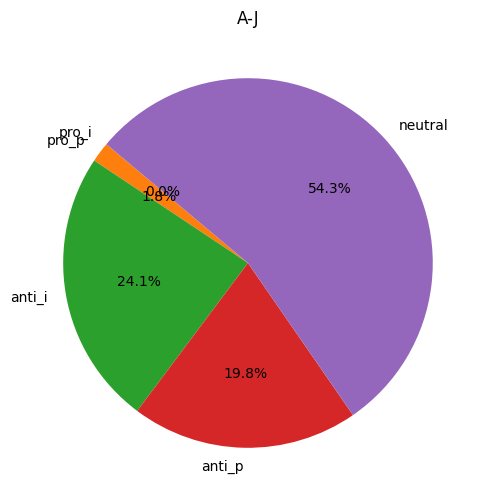

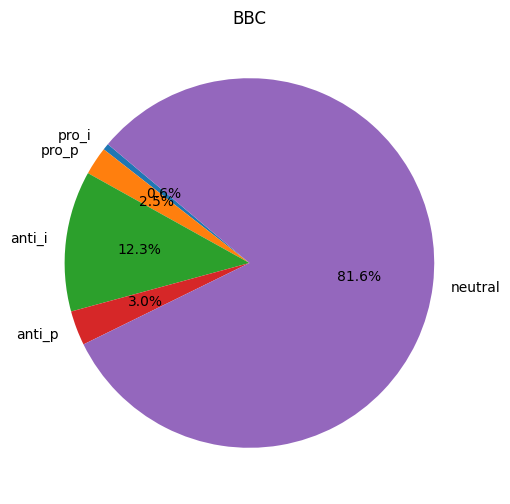

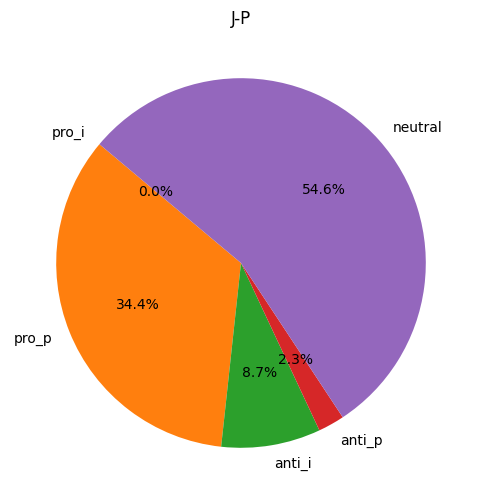

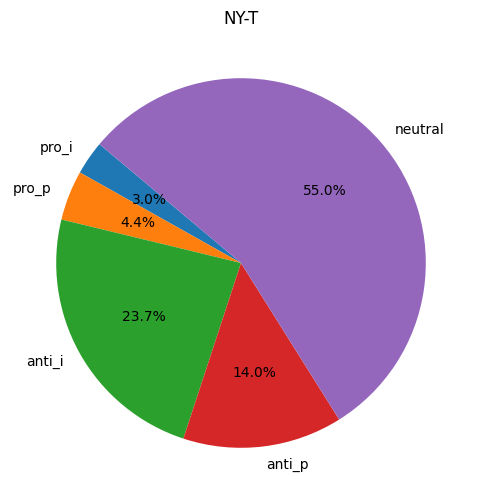

In [355]:
import matplotlib.pyplot as plt

# Plotting and saving each pie chart separately
for source, sentiments in papers_res.items():
    labels = sentiments.keys()
    sizes = sentiments.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(source)

    # Save the chart to a file
    plt.savefig(f'charts\\{source}_pie_chart.png')
    plt.show()
    plt.close()


In [358]:
len(articles_res)

5

In [365]:
for key, articles in articles_res.items():
    pd.DataFrame(articles).to_csv(f'res\\{key}.csv')